# SEP Forecasting 
***

Current physics based models of SEPs are unable to execute sufficiently fast in order to
provide actionable information towards forecasting such disturbances, which can impact
Earth within tens of minutes of the onset of an eruptive event. This is compounded by
the intrinsic latency of certain key observations, which are used to define the initial
conditions of these models. Instead, there is a reliance on statistical models to provide
forecast probabilities of Earth-bound SEPs using real-time data. Since the largest, most
impactful events occur infrequently, some regions of the feature space are sparse and
simple discrete binning procedures have limitations. The goal of this project is to
improve upon the empirical SEP proton prediction forecast model (PROTONS) currently
in operational use at SWPC, through the application of modern machine learning
techniques.

### Notebook summary

This notebook deals with the original Balch features - Soft X-ray ingrated flux, soxft X-ray peak flux, typeII and typeIV features __and is supplemented with features for the flare temperature and emission measure as seen by GOES__ (data taken from dataset compiled by doug's student i.e. from ControlEvents_student.xls)


Notebook contains logistic regression, decision trees and SVM. 

------

In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

from datetime import datetime,timedelta

from pandas.plotting import scatter_matrix

from sklearn.metrics import accuracy_score, confusion_matrix, make_scorer, recall_score, matthews_corrcoef
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, GridSearchCV
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.base import BaseEstimator, TransformerMixin, ClassifierMixin
from sklearn.utils import shuffle
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import confusion_matrix, roc_curve, brier_score_loss, precision_score
from sklearn.metrics import brier_score_loss as bsl
from sklearn.metrics import mean_squared_error as mse
from sklearn import preprocessing
from sklearn.utils.class_weight import compute_class_weight
#import scikitplot as skplt

from sklearn.model_selection import cross_val_score
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier as trees
from sklearn.svm import SVC

from scipy.sparse import csr_matrix, find


import seaborn as sns
sns.set()

### Read in and format the original Balch 2008 event list 

Choice of files: 

SPEall.v7p.xls - original SEP (only) event list from Balch 2008  
ctrlevents.v8p.xls - original event list (SEP + control) from Balch 2008  
ControlEvents_student.xls - Balch 2008 (SEP + control) event list with added CME speed and GOES T and EM from Dougs student

In [ ]:
#read in the original Balch SEP event list with added CME speed and GOES T and EM
#orig_data = pd.read_excel("ctrlevents.v8p.xls")

#adding y label column indicating positive and negative SEP events - SEP events have Association = ProtonFlare
#orig_data['sep'] = orig_data.Association.str.contains('^Proton').astype(int)

#convert the type II and type IV association to binary 
#orig_data.TypeII = (orig_data.TypeII.str.lower() == "yes").astype(int)
#orig_data.TypeIV = (orig_data.TypeIV.str.lower() == "yes").astype(int)

# Remove rows where optlocation = nan
##orig_data = orig_data[orig_data.optlocation.astype('str') != 'nan']

#shuffle the events so they are not organized 
#orig_data = shuffle(orig_data)

#save the shuffled dataframe -- commented out to prevent resaving
#orig_data.to_csv("AllEvtsShuffled_1986_2004.csv")


In [ ]:
#read in the students version Balch SEP event list with added CME speed and GOES T and EM
#orig_data = pd.read_excel("ControlEvents_student.xls")

#adding y label column indicating positive and negative SEP events - SEP events have Association = ProtonFlare
#orig_data['sep'] = orig_data.Association.str.contains('^Proton').astype(int)

#convert the type II and type IV association to binary 
#orig_data.TypeII = (orig_data.TypeII.str.lower() == "yes").astype(int)
#orig_data.TypeIV = (orig_data.TypeIV.str.lower() == "yes").astype(int)

# Remove rows where optlocation = nan
##orig_data = orig_data[orig_data.optlocation.astype('str') != 'nan']

#shuffle the events so they are not organized 
#orig_data = shuffle(orig_data)

#save the shuffled dataframe -- commented out to prevent resaving
#orig_data.to_csv("AllEvtsShuffled_1986_2004_cme.csv")



### Read in the new SEP events from 2004 onwards

Created by Pedro Brae

In [ ]:
#read in the SEP event list from 2004 - 2017
#new_data = pd.read_csv('sep_events_2004_2017.csv')


### Original Balch Features

From the original Balch 1999 and 2008 paper analysis only 4 features were used. GOES flare peak soft X-ray peak (1-8 A channel), flare soft X-ray integrated flux, occurrence of Type II and Type IV radio bursts.

In [3]:
class BalchPaperFeatures(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        
        """Class to create original 4 features from Balch 2008"""
        
        return None
    
    def fit(self, examples):
        # return self and nothing else 
        return self
    
    def get_feature_names(self):
        """Array mapping from feature integer indices to feature name"""
        
        return ['TypeII','TypeIV','FlrPeakFlux','FlrIntFlux2']
    
    def transform(self, examples):
                
        #Choose the orginal 4 Balch 2008 features
        X = examples[['TypeII','TypeIV','FlrPeakFlux','FlrIntFlux2']]
        
        return(X)

### Raw features

Other features read directly from the original event list i.e. the flare integrated soft X-ray flux at the GOES short wavelength channel (0.5 - 1 A), the GOES temperature and GOES emission measure

In [4]:
class RawFeatures(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        
        """Other features from the Event List that don't need to be manipulated before being included in model"""
        
        return None
    
    def fit(self, examples):
        # return self and nothing else 
        return self
    
    def get_feature_names(self):
        """Array mapping from feature integer indices to feature name"""
        
        #return ['FlrIntFlux','tchianti','emchianti']
        return ['tchianti','emchianti', '1MHz_fluence']
    
    def transform(self, examples):
                
        #Choose the orginal 4 Balch 2008 features (5 if you include both type II and type Iv as separate features)
        #X = examples[['FlrIntFlux','tchianti','emchianti']]
        X = examples[['tchianti','emchianti','1MHz_fluence']]

        return(X)

### Flare time to peak

The time between the flare onset and the flare peak time

In [5]:
class FlareTime2Peak(BaseEstimator, TransformerMixin):
    
    """Class to create feature with the time between flare onset to flare max time"""
    
    def __init__(self):
        
        return None
    
    def fit(self, examples):
        # return self and nothing else 
        return self
    
    def get_feature_names(self):
        """Array mapping from feature integer indices to feature name"""
        
        return ["FlTim2Pk"]
    
    def transform(self, examples):
        
        # Initiaize matrix 
        X = np.zeros((len(examples),1))           

        #time between flare max and flare onset
        X[:,0] = np.asarray([(mx - on).seconds for mx, on in zip(examples.Flrmaxtime, examples.FlrOnset)])
        
        return(X)

### Flare location

The flare location formatted from N16W12 format to North-South and East-West of disk center values

In [6]:
class LocationFeatures(BaseEstimator, TransformerMixin):
   
    """Class to create feature with the time between flare onset to flare max time"""
   
    def __init__(self):
       
        return None
   
    def fit(self, examples):
        # return self and nothing else 
        return self
   
    def get_feature_names(self):
        """Array mapping from feature integer indices to feature name"""
       
        return ['NS', 'EW']
   
    def transform(self, examples):
       
        # Initiaize matrix 
        X = np.zeros((len(examples),2))  
       
        #time between flare max and flare onset
        #X[:,0] = np.asarray([str(x)[1:3] for x in examples.optlocation])   #north - south
        #X[:,1] = np.asarray([str(x)[4::] for x in examples.optlocation])   #north - south
       
        for i,loc in enumerate(examples.optlocation):
            lat = str(loc)[1:3]
            if str(loc)[0] == 's' or str(loc)[0] == 'S':
                X[i,0] = -int(lat)
            else:
                X[i,0] = (lat)

            #west-east
            long = str(loc)[4::]
            if str(loc)[3] == 'w' or str(loc)[3] == 'W':
                X[i,1] = -int(long)
            else:
                X[i,1] = int(long)

        return(X)

### SEP Class 

With functions to build the training feature list from the above feature extractors

In [31]:
class SEPClass(BaseEstimator, ClassifierMixin):
    def __init__(self, estimator, folds = 5, threshold=0.5):        # <--- other keywords to be used by Feature Union go here
        
        """Class to fit and train Logistic Regression algorithm for SEP forecasting
        
        Input keywords:
        
        folds:        Number of cross validation folds to use
        threshold:    Decision Boundary threshold
        
        """
        
        self.estimator = estimator     #estimator to use for classification e.g. LogReg or SVM
        self.folds = folds             #cross validation folds for estimator
        self.threshold = threshold     #decision boundary threshold
    
        #Set up the Feature union to combine Feature creating classes
        self.allmyfeatures = FeatureUnion([
            ("BalchFeat", BalchPaperFeatures()),
            ("RawFeat", RawFeatures()),
            ("LocFeatures", LocationFeatures())#,
            #("FlareTime2Peak", FlareTime2Peak())   
        ])
    
    def build_train_features(self, examples):
        """
        Method to take in training text features and do further feature engineering 
        Most of the work in this homework will go here, or in similar functions  
        :param examples: currently just a list of forum posts  
        """  
        
        ##convert columns of time from string to datetime -- MOVE TO SEPARATE CLEANING FUNCTION
        #examples.FlrOnset = pd.Series(datetime.strptime(t, "%Y-%m-%dT%H:%M:%S.%f") for t in examples.FlrOnset)
        #examples.Flrmaxtime = pd.Series(datetime.strptime(t, "%Y-%m-%dT%H:%M:%S.%f") for t in examples.Flrmaxtime)
        #examples.Flrendtime = pd.Series(datetime.strptime(t, "%Y-%m-%dT%H:%M:%S.%f") for t in examples.Flrendtime)
        #examples.FlrHpTime = pd.Series(datetime.strptime(t, "%Y-%m-%dT%H:%M:%S.%f") for t in examples.FlrHpTime)
                
        return self.allmyfeatures.fit_transform(examples)
        #normalize data here?

    def get_test_features(self, examples):
        """
        Method to take in test text features and transform the same way as train features 
        :param examples: currently just a list of forum posts  
        """
    
        return self.allmyfeatures.transform(examples)

    def show_topX(self, num=3):
        """
        prints the top num features for the positive class and the 
        top 10 features for the negative class. 
        """
        feature_names = np.asarray([x.split("__")[1] for x in self.allmyfeatures.get_feature_names()])
        topX = np.argsort(self.estimator.coef_[0])[-num:]
        bottomX = np.argsort(self.estimator.coef_[0])[:num]
        
        print(feature_names)
        
        print("\nTop 3 features for Pos and Neg\n-------------------------")
        for fn in np.arange(1,num):
            print("Pos %i: %s %f" % (fn, feature_names[topX[-fn]], self.estimator.coef_[0,topX[-fn]]))
        for fn in np.arange(0,num-1):
            print("Neg %i: %s %f" % (fn, feature_names[bottomX[fn-1]], self.estimator.coef_[0,bottomX[fn-1]]))
            
      
    def show_misclassified(self):     

        """
        Method to show the misclassified examples i.e. False Positives and False negatives 
        """
        
        #get all the feature names
        #words = feat.allmyfeatures.get_feature_names() #####
        words = self.allmyfeatures.get_feature_names() #####
        
        # False positives
        print("\nSome misclassified examples:")
        falsepos = np.where((self.train_pred != self.y_train) & (self.train_pred == 1))[0]   #all false pos example rows
        print("\nPredicted SEP but labeled AllClear (False Pos) \n------------------------- ")

        for i in range(len(falsepos[0:10])):         #loop through falsepos examples
            weights_falsepos = []
            x = find(feat.X_train[falsepos[i]])      #find which features are used for this example
            for ii in x[1]:                          #from sparse matrix get column indices corresponding to features
                weights_falsepos.append((words[ii].split('__')[1], self.estimator.coef_[0,ii]))      #get the word and weight

            print("label: %i, prediction %i, Neg Prob: %f, Pos Prob: %f, Ex No.: %i,  example: %s " % \
                (self.y_train[falsepos[i]], self.train_pred[falsepos[i]] , self.train_pred_prob[falsepos[i]][0], \
                     self.train_pred_prob[falsepos[i]][1], falsepos[i], self.clean_examples[falsepos[i]]))
            for j in weights_falsepos:
                print(j)
                
        # False Negatives
        falseneg = np.where((self.train_pred != self.y_train) & (self.train_pred == 0))[0]
        print("\nPredicted AllClear but labeled SEP (False Neg) \n-------------------------")

        for i in range(len(falseneg[0:10])):
            weights_falseneg = []
            x = find(feat.X_train[falseneg[r]])
            for ii in x[1]:
                weights_falseneg.append((words[ii].split('__')[1], self.estimator.coef_[0,ii])) 

            print("label: %i, prediction %i, Neg Prob: %f, Pos Prob: %f, Ex No.: %i, \nexample: %s " % \
                (self.y_train[falseneg[i]], self.train_pred[falseneg[i]], self.train_pred_prob[falseneg[i]][0], \
                 self.train_pred_prob[falseneg[i]][1], falseneg[i], self.clean_examples[falseneg[i]]))
            for j in weights_falseneg:
                print(j)
        
        print("\n\n")
        print(words)
       
    def show_report(self, X, y, y_pred, y_pred_prob):
        
        """Method to show a report card of the model fit. Generalized to work for both the training and test sets
            
            X : features 
            y : labels
            y_pred : predicted labels 
            y_pred_prob : predicted probabilities

        """
        
        #print the model parameters
        print("Model Parameters \n-----------------------------------\n")
        print(self,'\n')
        
        #print the shape of the training features
        print("Features \n-----------------------------------\n")
        
        print("Shape of the Features: Num examples x Num Features")
        print(X.shape,'\n')

        #print the names of the features
        print("Feature Names: \n")
        names = self.allmyfeatures.get_feature_names()
        for n in names:
            print(n)
        print('\n')
        
        #print("\nTRAINING SET\n-------------------------------------------------------------\n")
        
        # Add confusion Matrix
        tn, fp, fn, tp=confusion_matrix(y, y_pred).ravel()
        print("True Pos: %i, True Neg: %i, False Pos: %i,. False Neg: %i\n" % (tp,tn,fp,fn))

        FAR = fp/(tp + fp)
        POD = tp/(tp + fn)
        #TSS = tp / (tp+fp+fn)
        TSS = tp / (tp + fn) - fp / (fp + tn)
        E = ((tp + fn)*(tp + fp) + (fp + tn)*(fn + tn)) / X.shape[0]
        HSS = (tp + tn - E)/(X.shape[0] - E)

        print("FAR: %.4f" % FAR)
        print("POD: %.4f" % POD)
        print("TSS: %.4f" % TSS)
        print("HSS: %.4f" % HSS)
        
        print("\nCross Validation Metric Scores\n-----------------------------------\n")
        
        #recall
        metric1 = 'recall'
        rec_score = cross_val_score(self.estimator, X, y, \
                                    cv=self.folds,scoring=metric1)
        print(metric1)
        print(rec_score)
        print("mean: %.4f, stddev: %.4f \n" % (rec_score.mean(), rec_score.std()))
        
        #precision
        metric2 = 'precision'
        prec_score = cross_val_score(self.estimator, X, y, \
                                     cv=self.folds,scoring=metric2)
        print(metric2)
        print(prec_score)
        print("mean: %.4f, stddev: %.4f \n" % (prec_score.mean(), prec_score.std()))
    
        #matthews correlation
        metric3s = 'matthews correlation coefficient' 
        metric3 = make_scorer(matthews_corrcoef)
        mattco_score = cross_val_score(self.estimator, X, y, \
                                       cv=self.folds,scoring=metric3)
        print(metric3s)
        print(mattco_score) 
        print("mean: %.4f, stddev: %.4f \n" % (mattco_score.mean(), mattco_score.std()))
    
        #brier
        metric4s = "brier score" 
        metric4 = make_scorer(brier_score_loss)
        brier_score = cross_val_score(self.estimator, X, y, cv=self.folds,scoring=metric4)
        print(metric4s)
        print(brier_score)  
        print("mean: %.4f, stddev: %.4f \n" % (brier_score.mean(), brier_score.std()))
        
        #TSS
        def tss_score(y, y_pred):
            tn, fp, fn, tp=confusion_matrix(y, y_pred).ravel()
            #tss = tp / (tp + fp + fn)
            tss = tp / (tp + fn) - fp / (fp + tn)
            return tss
        
        metric5s = "TSS" 
        metric5 = make_scorer(tss_score)
        tss_score = cross_val_score(self.estimator, X, y, cv=self.folds,scoring=metric5)
        print(metric5s)
        print(tss_score)
        print("mean: %.4f, stddev: %.4f \n" % (tss_score.mean(), tss_score.std()))
        
        #HSS
        def hss_score(y, y_pred):
            tn, fp, fn, tp=confusion_matrix(y, y_pred).ravel()
            E = ((tp + fn)*(tp + fp) + (fp + tn)*(fn + tn)) / len(y)
            HSS = (tp + tn - E)/(len(y) - E)
            return HSS
        
        metric6s = "HSS" 
        metric6 = make_scorer(hss_score)
        hss_score = cross_val_score(self.estimator, X, y, cv=self.folds,scoring=metric6)
        print(metric6s)
        print(hss_score)
        print("mean: %.4f, stddev: %.4f \n" % (hss_score.mean(), hss_score.std()))
        
        
        #cross validation
        #print("\nCross Validation Accuracy Scores (cross_val_predict)\n-------------------------")
        #self.y_pred = cross_val_predict(self.estimator, self.X_train, self.y_train, cv=self.folds)
        #print(self.score(self.y_pred, self.y_train))
                
        #training set score (no cross-validation)
        print('\nFull dataset (no cross-validation) Score \n-----------------------------------\n')
        
        rec1_score = recall_score(y,y_pred)
        print("Recall: %.4f" % rec1_score)
        
        prec1_score = precision_score(y,y_pred)
        print("Precision: %.4f" % prec1_score,'\n')        
        
        mattco1_score = matthews_corrcoef(y,y_pred)
        print("Mathews Corr: %.4f" % mattco1_score,'\n')        

        #calculate the mean square error
        mserr = mse(y, y_pred)
        print("MSE: %.4f" % mserr)

        #calculate the Brier score - is this the same as the MSE? And QR referenced in Balch paper?
        bsloss = bsl(y, y_pred_prob[:,1])
        print("BSL: %.4f" % bsloss)

        #Occurance rate = #SEPS / #events
        occ_rate = y.sum()/len(y)

        #Reference score of predicting all negative class
        #QR_star = 0.0324 Balch
        QR_star =  mse(y, np.zeros(len(y)))
        print("RefQuadScore: %.4f\n" % QR_star)

        #assume the QR is the same as the MSE - as stated later in Balch
        QR = mserr
        #QR = 0.0250 Balch

        #skill score 
        SS = (QR_star - QR)/QR_star
        print("SS: %.4f\n" % SS)

        FAR = fp/(tp + fp)
        POD = tp/(tp + fn)
        #TSS = tp / (tp+fp+fn)
        TSS = tp / (tp + fn) - fp / (fp + tn)
        E = ((tp + fn)*(tp + fp) + (fp + tn)*(fn + tn)) / X.shape[0]
        HSS = (tp + tn - E)/(X.shape[0] - E)

        print("FAR: %.4f" % FAR)
        print("POD: %.4f" % POD)
        print("TSS: %.4f" % TSS)
        print("HSS: %.4f" % HSS)
        
        ##ROC metrics
        #fpr, tpr, thresh = roc_curve(self.y_train, self.y_train_pred, drop_intermediate=False)

    def roc_curve(self):
        
        """plot and ROC curve"""
        
        # Initial implementation of ROC plot applied to training set
        skplt.metrics.plot_roc_curve(self.y_train, self.y_train_probas)
        
    def score(self, X, y):

        """find the accuracy score given the training data and labels"""
        #print("...In Score...")
        #print("threshold:", self.threshold)
        
        #y_pred = (self.estimator.predict(X) > self.threshold).astype(int)
        
        #tn, fp, fn, tp=confusion_matrix(y, y_pred).ravel()
        #return tp/(tp+fp+fn)
        
        return accuracy_score(y, y_pred)
        
    def fit(self, X, y, verbose = True):    #, random_state=1234):
        """
        Method to read in training data from file, and 
        train Logistic Regression classifier. 
        
        :param random_state: seed for random number generator 
        """
        
        from sklearn.linear_model import LogisticRegression 
        
        # load data 
        #self.dfTrain = pd.read_csv("AllEvtsShuffled.csv")
                      
        # get training features and labels 
        #self.X_train = self.build_train_features(self.dfTrain)    #CHANGE
        #self.y_train = np.array(self.dfTrain.sep, dtype=int)
        
        self.X_train = X 
        self.y_train = y 
        
        #print the shape of the features
        #print("Shape of the Features: Num examples x Num Features")
        #print(self.X_train.shape)
        #print("examples...:", self.X_train[0:10])

        #self.logreg.fit(self.X_train, self.y_train)
        self.estimator.fit(self.X_train, self.y_train)
        
        # make predictions on training data 
        self.y_train_pred = self.estimator.predict(self.X_train)

        #return the LogReg probabilities used to classify each example  
        self.y_train_pred_prob = self.estimator.predict_proba(self.X_train)
        

        #print report card
        if verbose:
            print("\nTraining Set Report Card:\n----------------------------------------\n")
            print(self.show_report(self.X_train, self.y_train, self.y_train_pred, self.y_train_pred_prob))
        
    
    def predict(self, X, y, verbose = True):
        
        """
        Return predicted labels for exmaples X. 
 
        """
        
        self.X_test = X
        self.y_test = y
    
        self.y_test_pred = self.estimator.predict(self.X_test)
        self.y_test_pred_prob = self.estimator.predict_proba(self.X_test)
        
        if verbose:
            print("\nTest Set Report Card:\n----------------------------------------\n")
            print(self.show_report(self.X_test, self.y_test, self.y_test_pred, self.y_test_pred_prob))
        
 

### Read in data

Read in the shuffled data split into training and test sets - note: neither the training or the test data is featuized at this point.


In [8]:
#read in the shuffled dataframe of original sep+ctrl events from 1986 - 2004
#with added new features (T, EM, 1MHz fluence)
orig_data = pd.read_csv("AllEvtsShuffled_1986_2004_t_em_1mhz.csv")

#feature_data_old refers to events from 1986 to 2004
#feature_data_old = orig_data[['FlrOnset','Flrmaxtime','FlrPeakFlux','FlrIntFlux2','TypeII','TypeIV','optlocation','tchianti','emchianti','FlrIntFlux','sep']]
feature_data_old = orig_data[['FlrOnset','Flrmaxtime','FlrPeakFlux','FlrIntFlux2','TypeII','TypeIV','optlocation','FlrIntFlux','tchianti','emchianti','1MHz_fluence','sep']]

# Remove rows where optlocation = nan
feature_data_old_no_nan = feature_data_old[feature_data_old.optlocation.astype('str') != 'nan']

#remove rows where tchianti, emchianti, 1MHz_fluence = nan, 
feature_data_old_no_nan = feature_data_old_no_nan.dropna(how='any')

dfTrain = feature_data_old_no_nan.dropna(how='any')

# to add in the SEP events from 2004 to 2017 uncomment this section
#feature_data_new = new_data[['FlrOnset','Flrmaxtime','FlrPeakFlux','FlrIntFlux2','TypeII','TypeIV','optlocation','tchianti','emchianti','FlrIntFlux','sep']]
#dfTrain = pd.concat([feature_data_old,feature_data_new])

#drop 7 samples where dfTrain FlrIntFlux2 is erroneously greater than 1000.0 (all control events)
dfTrain = dfTrain[dfTrain.FlrIntFlux2 < 1000.0]

#split dataset into training and test - not yet featurized - needs to be done after
#statement regarding how many features to use
labels = np.array(dfTrain.sep, dtype=int)
X_train0, X_test0, y_train0, y_test0 = train_test_split(dfTrain,labels,\
                            test_size=0.2, random_state=1230, stratify=labels)


In [20]:
print("lenght of original feature data set: Total: %i, No Seps: %i Sep: %i" % \
     (len(feature_data_old), len(feature_data_old.query('sep == 0.0')), len(feature_data_old.query('sep == 1.0'))))
print("lenght of feature data set without NaN rows: Total: %i, No Seps: %i Sep: %i" % \
     (len(feature_data_old_no_nan), len(feature_data_old_no_nan.query('sep == 0.0')), len(feature_data_old_no_nan.query('sep == 1.0'))))


lenght of original feature data set: Total: 3784, No Seps: 3657 Sep: 127
lenght of feature data set without NaN rows: Total: 1181, No Seps: 1121 Sep: 60


In [ ]:
#print("No. of events lost due to NaN location: All events: %i, No Loc Nan %i (-%i)" % \
#      (len(feature_data_old), len(feature_data_old_no_loc_nan), len(feature_data_old)-len(feature_data_old_no_loc_nan)))

In [24]:
#len(dfTrain.query('sep == 1'))

In [23]:
#check that there are no Nan values
#dfTrain.isna().any()

### Taking a look at the parameter distributions

In [52]:
seps = dfTrain.query('sep == 1')
ctrl = dfTrain.query('sep == 0')

sep0 = dfTrain.query('sep == 1 and TypeII == 0 and TypeIV == 0')
sep1 = dfTrain.query('sep == 1 and TypeII == 1 and TypeIV == 0')
sep2 = dfTrain.query('sep == 1 and TypeII == 0 and TypeIV == 1')
sep3 = dfTrain.query('sep == 1 and TypeII == 1 and TypeIV == 1')

ctrl0 = dfTrain.query('sep == 0 and TypeII == 0 and TypeIV == 0')
ctrl1 = dfTrain.query('sep == 0 and TypeII == 1 and TypeIV == 0')
ctrl2 = dfTrain.query('sep == 0 and TypeII == 0 and TypeIV == 1')
ctrl3 = dfTrain.query('sep == 0 and TypeII == 1 and TypeIV == 1')

In [ ]:
#fig, ax0 = plt.subplots(figsize = (20,10), projection='3d')

fig = plt.figure(figsize = (10,10))
ax0 = fig.add_subplot(111, projection='3d')
#ax1 = fig.add_subplot(312, projection='3d')
#ax2 = fig.add_subplot(313, projection='3d')

##[plot with goes T]
sx = 50
ax0.scatter(ctrl0.FlrIntFlux2, ctrl0.FlrPeakFlux, ctrl0.emchianti*ctrl0.tchianti, c = 'b', marker = 'o', s = sx, label = 'CTRL No bursts')
ax0.scatter(ctrl1.FlrIntFlux2, ctrl1.FlrPeakFlux, ctrl1.emchianti*ctrl1.tchianti, c = 'b', marker = 'v', s = sx, label = 'CTRL Type II')
ax0.scatter(ctrl2.FlrIntFlux2, ctrl2.FlrPeakFlux, ctrl2.emchianti*ctrl2.tchianti, c = 'b', marker = '+', s = sx, label = 'CTRL Type IV')
ax0.scatter(ctrl3.FlrIntFlux2, ctrl3.FlrPeakFlux, ctrl3.emchianti*ctrl3.tchianti, c = 'b', marker = 'x', s = sx, label = 'CTRL Type II/IV')

ax0.scatter(sep0.FlrIntFlux2, sep0.FlrPeakFlux, sep0.emchianti*sep0.tchianti, c = 'r', marker = 'o', s = sx, label = 'SEP No bursts')
ax0.scatter(sep1.FlrIntFlux2, sep1.FlrPeakFlux, sep1.emchianti*sep1.tchianti, c = 'r', marker = 'v', s = sx, label = 'SEP Type II')
ax0.scatter(sep2.FlrIntFlux2, sep2.FlrPeakFlux, sep2.emchianti*sep2.tchianti, c = 'r', marker = '+', s = sx, label = 'SEP Type IV')
ax0.scatter(sep3.FlrIntFlux2, sep3.FlrPeakFlux, sep3.emchianti*sep3.tchianti, c = 'r', marker = 'x', s = sx, label = 'SEP Type II/IV')

ax0.set_xlabel('FlrIntFlux2 (bkg sub)')
ax0.set_ylabel('FlrPeakFlux')
ax0.set_zlabel('GOES T*EM')


#ax0.set_ylim(top = 0.002, bottom = 0)
#ax.set_yscale('log')
#ax.set_xscale('log')
ax0.legend()

plt.show()




In [ ]:
fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(2,2, figsize = (10,10))

sx = 50
ax0.scatter(ctrl0.FlrIntFlux2, ctrl0.FlrPeakFlux, c = 'b', marker = 'o', s = sx, label = 'CTRL No bursts')
ax0.scatter(sep0.FlrIntFlux2, sep0.FlrPeakFlux, c = 'r', marker = 'o', s = sx, label = 'SEP No bursts')
ax0.set_xlabel('FlrIntFlux2 (bkg sub)')
ax0.set_ylabel('FlrPeakFlux')
ax0.set_ylim(top = 0.002, bottom = 0)
ax0.legend()

ax1.scatter(ctrl1.FlrIntFlux2, ctrl1.FlrPeakFlux, c = 'b', marker = 'v', s = sx, label = 'CTRL Type II')
ax1.scatter(sep1.FlrIntFlux2, sep1.FlrPeakFlux, c = 'r', marker = 'v', s = sx, label = 'SEP Type II')
ax1.set_xlabel('FlrIntFlux2 (bkg sub)')
ax1.set_ylabel('FlrPeakFlux')
ax1.set_ylim(top = 0.002, bottom = 0)
ax1.legend()

ax2.scatter(ctrl2.FlrIntFlux2, ctrl2.FlrPeakFlux, c = 'b', marker = '+', s = sx, label = 'CTRL Type IV')
ax2.scatter(sep2.FlrIntFlux2, sep2.FlrPeakFlux, c = 'r', marker = '+', s = sx, label = 'SEP Type IV')
ax2.set_xlabel('FlrIntFlux2 (bkg sub)')
ax2.set_ylabel('FlrPeakFlux')
ax2.set_ylim(top = 0.002, bottom = 0)
ax2.legend()

ax3.scatter(ctrl3.FlrIntFlux2, ctrl3.FlrPeakFlux, c = 'b', marker = 'x', s = sx, label = 'CTRL Type II/IV')
ax3.scatter(sep3.FlrIntFlux2, sep3.FlrPeakFlux, c = 'r', marker = 'x', s = sx, label = 'SEP Type II/IV')
ax3.set_xlabel('FlrIntFlux2 (bkg sub)')
ax3.set_ylabel('FlrPeakFlux')
ax3.set_ylim(top = 0.002, bottom = 0)
ax3.legend()

#ax.set_yscale('log')
#ax.set_xscale('log')



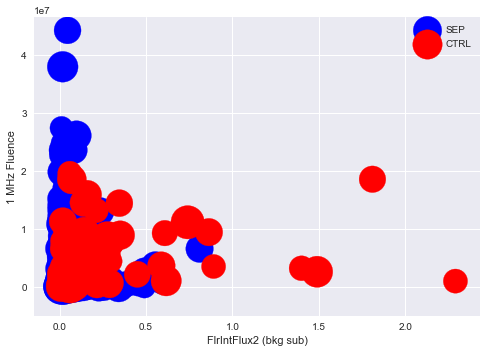

In [65]:
#fig = plt.figure(figsize = (10,10))
#ax0 = fig.add_subplot(111)

f, ax0 = plt.subplots(1,1)

ax0.scatter(ctrl.FlrIntFlux2, ctrl['1MHz_fluence'], ctrl0.emchianti*ctrl0.tchianti, c = 'b', label = 'SEP')
ax0.scatter(seps.FlrIntFlux2, seps['1MHz_fluence'], ctrl1.emchianti*ctrl1.tchianti, c = 'r', label = 'CTRL')

ax0.set_xlabel('FlrIntFlux2 (bkg sub)')
ax0.set_ylabel('1 MHz Fluence')
ax0.legend()

plt.show()



****

# Logistic Regression

*****

### Initialize SEP object and create feature data

The Logisitic Regression classifier to initialize an SEP object and generate the feature data for training and test sets.

NOTE: remember to set sepLR.allmyfeatures.set_params() correctly here and a few cells later after the gridsearchcv. Need to find away to update the object keywords with the gridsearchcv best_params without having to reintialze the object.

In [32]:
#Initialize SEPClass instance with an estimator of choice - here Logisitic Regression
#with estimator specific keywords 
keywordsLR = {'random_state':1230, 'max_iter':500, 'class_weight':'balanced', 'C':0.9, 'verbose':0, 'solver':'liblinear'}

#sep_weights = {0:12,1:39} #dictionary for experimental class weights
sepLR = SEPClass(LogisticRegression(**keywordsLR),threshold = 0.5)
                                    #, class_weight = 'balanced', \
#                C=0.9,verbose=0,solver='newton-cg'),threshold = 0.5)

#Turn off features. Options: BalchFeat, RawFeat,LocFeatures
sepLR.allmyfeatures.set_params()

# convert each event into features and labels 
X_train = sepLR.build_train_features(X_train0)    
y_train = y_train0

X_test = sepLR.build_train_features(X_test0)    
y_test = y_test0

#standardization - don't standardize the first 2 columns - these are the binary type II/IV features
scaler = preprocessing.StandardScaler().fit(X_train[:,2::])

X_train = np.hstack([X_train[:,0:2], scaler.transform(X_train[:,2::])]) 
X_test = np.hstack([X_test[:,0:2], scaler.transform(X_test[:,2::]) ]) 





In [33]:
X_train.shape

(943, 9)

In [34]:
sepLR.allmyfeatures.get_feature_names()

['BalchFeat__TypeII',
 'BalchFeat__TypeIV',
 'BalchFeat__FlrPeakFlux',
 'BalchFeat__FlrIntFlux2',
 'RawFeat__tchianti',
 'RawFeat__emchianti',
 'RawFeat__1MHz_fluence',
 'LocFeatures__NS',
 'LocFeatures__EW']

### Hypertune Logisitic Regression parameters with GridSearchCV

Scorers to asses opitimization of hyperparameters using GridSearchCV

In [35]:
# set up some scorers to work with GridSearchCV
metric3 = make_scorer(matthews_corrcoef)

def tss_score(y, y_pred):
    tn, fp, fn, tp=confusion_matrix(y, y_pred).ravel()
    #tss = tp / (tp + fp + fn)
    #print(tn, tp, fn, fp)
    tss = tp / (tp + fn) - fp / (fp + tn)
    #print(tss)
    return tss

def hss_score(y, y_pred):
    tn, fp, fn, tp=confusion_matrix(y, y_pred).ravel()
    #print(tn, tp, fn, fp)
    E = ((tp + fn)*(tp + fp) + (fp + tn)*(fn + tn)) / X_train.shape[0]
    HSS = (tp + tn - E)/(X_train.shape[0] - E)
    #print(HSS)
    return HSS

metric5 = make_scorer(tss_score)
metric6 = make_scorer(hss_score)

GridsearchCV results

In [36]:
#hyperparameter ranges
#CV_dictLR = {'C':np.arange(0.0052,0.11,0.01),'class_weight':[None,'balanced'],\
#           'solver':['liblinear','newton-cg','lbfgs']}

CV_dictLR = {'C':np.array([1.e-8, 1.e-7, 1e-6, 1e-5, 1.e-4, 1.e-4, 1.e-3, 1.e-2, 1.e-1, 1.0, 10., 100.0, 1.e3, 1.e4, 1.e5])}

##note passing SEPClass object sep directly to gridsearchcv
cv_searchLR = GridSearchCV(estimator = sepLR.estimator, param_grid = CV_dictLR, scoring = metric6, cv=5)   
cv_searchLR.fit(X_train,y_train)
cv_resultLR = cv_searchLR.best_params_
print(cv_resultLR)

{'C': 10.0}


#### Tunning to HSS
Plot of regularization tuning parameter vs HSS scorer

SEPClass(estimator=LogisticRegression(C=100000.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=500,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=1230,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False),
     folds=5, threshold=0.5)


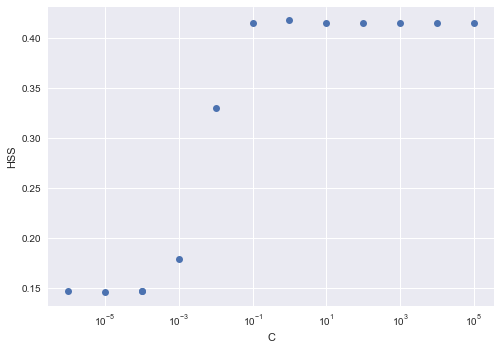

In [37]:
hss_plot = []
#c = np.arange(0.1,1.1,0.01)
c = np.array([1e-6, 1e-5, 1.e-4, 1.e-4, 1.e-3, 1.e-2, 1.e-1, 1.0, 10., 100.0, 1.e3, 1.e4, 1.e5])
for i in c:

    keywordsLR.update({'C': i, 'class_weight': 'balanced'})
    #print(keywordsLR)
    sepLR = SEPClass(LogisticRegression(**keywordsLR),threshold = 0.5)
    #sepLR.allmyfeatures.set_params(LocFeatures=None,RawFeat=None)
    sepLR.fit(X_train, y_train, verbose = False)

    hss_plot.append(hss_score(sepLR.y_train, sepLR.y_train_pred))
    tn, fp, fn, tp=confusion_matrix(sepLR.y_train, sepLR.y_train_pred).ravel()
    #print(tn,fp,fn,tp)
    #print(np.sum(sepLR.y_train))
    
plt.plot(c, hss_plot, 'o')
plt.ylabel("HSS")
plt.xlabel("C")
plt.xscale('log')
    
print(sepLR)  

#### Tunning to TSS
Plot of regularization tuning parameter vs TSS scorer

SEPClass(estimator=LogisticRegression(C=100000.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=500,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=1230,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False),
     folds=5, threshold=0.5)


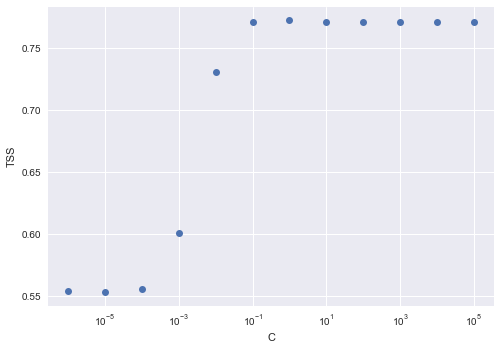

In [45]:
tss_plot = []
#c = np.arange(0.1,1.1,0.01)
c = np.array([1e-6, 1e-5, 1.e-4, 1.e-3, 1.e-2, 1.e-1, 1.0, 10., 100.0, 1.e3, 1.e4, 1.e5])
for i in c:

    keywordsLR.update({'C': i, 'class_weight': 'balanced'})
    #print(keywordsLR)
    sepLR = SEPClass(LogisticRegression(**keywordsLR),threshold = 0.5)
    #sepLR.allmyfeatures.set_params(LocFeatures=None,RawFeat=None)
    sepLR.fit(X_train, y_train, verbose = False)

    tss_plot.append(tss_score(sepLR.y_train, sepLR.y_train_pred))
    tn, fp, fn, tp=confusion_matrix(sepLR.y_train, sepLR.y_train_pred).ravel()
    #print(tn,fp,fn,tp)
    #print(np.sum(sepLR.y_train))
    
plt.plot(c, tss_plot, 'o')
plt.ylabel("TSS")
plt.xlabel("C")
plt.xscale('log')
    
print(sepLR)  

confusion matrix vs regularization parameter

In [46]:

keywordsLR1 = {'random_state':1230, 'max_iter':500, 'class_weight':'balanced', \
              'C':1.0, 'verbose':0, 'solver':'liblinear'}
sepLR1 = SEPClass(LogisticRegression(**keywordsLR1),threshold = 0.5)
#sepLR1.allmyfeatures.set_params(LocFeatures=None,RawFeat=None)
sepLR1.fit(X_train, y_train, verbose = False)

print("C: 1.0")
print(sepLR1)
print("HSS: %.4f " % hss_score(sepLR1.y_train, sepLR1.y_train_pred))
print("TSS: %.4f " % tss_score(sepLR1.y_train, sepLR1.y_train_pred))
tn1, fp1, fn1, tp1 = confusion_matrix(sepLR1.y_train, sepLR1.y_train_pred).ravel()
print("True Pos: %i, True Neg: %i, False Pos: %i,. False Neg: %i" % (tp1,tn1,fp1,fn1))
print("POD: %.4f, FAR: %.4f" % (tp1/(tp1 + fn1), fp1/(tp1 + fp1)))  
print(sepLR1.allmyfeatures.get_feature_names())
print(sepLR1.estimator.coef_)

C: 1.0
SEPClass(estimator=LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=500,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=1230,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False),
     folds=5, threshold=0.5)
HSS: 0.4179 
TSS: 0.7722 
True Pos: 42, True Neg: 803, False Pos: 92,. False Neg: 6
POD: 0.8750, FAR: 0.6866
['BalchFeat__TypeII', 'BalchFeat__TypeIV', 'BalchFeat__FlrPeakFlux', 'BalchFeat__FlrIntFlux2', 'RawFeat__tchianti', 'RawFeat__emchianti', 'RawFeat__1MHz_fluence', 'LocFeatures__NS', 'LocFeatures__EW']
[[ 0.67457007  1.83701225  0.44004433  1.11900481 -1.90265799  1.46766274
   0.39906218  0.05133287 -0.8537184 ]]


In [47]:
keywordsLR3 = {'random_state':1230, 'max_iter':500, 'class_weight':'balanced', \
              'C':1, 'verbose':0, 'solver':'liblinear'}
sepLR3 = SEPClass(LogisticRegression(**keywordsLR3),threshold = 0.5)
sepLR3.allmyfeatures.set_params(LocFeatures=None,RawFeat=None)
sepLR3.fit(X_train, y_train, verbose = False)

print("C: 1")
print(sepLR3)
print("HSS: %.4f " % hss_score(sepLR3.y_train, sepLR3.y_train_pred))
print("TSS: %.4f " % tss_score(sepLR3.y_train, sepLR3.y_train_pred))
tn3, fp3, fn3, tp3 = confusion_matrix(sepLR3.y_train, sepLR3.y_train_pred).ravel()
print("True Pos: %i, True Neg: %i, False Pos: %i,. False Neg: %i" % (tp3,tn3,fp3,fn3))
print("POD: %.4f, FAR: %.4f" % (tp3/(tp3 + fn3), fp3/(tp3 + fp3)))  
print(sepLR3.allmyfeatures.get_feature_names())
print(sepLR3.estimator.coef_)

C: 1
SEPClass(estimator=LogisticRegression(C=1, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=500,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=1230,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False),
     folds=5, threshold=0.5)
HSS: 0.4179 
TSS: 0.7722 
True Pos: 42, True Neg: 803, False Pos: 92,. False Neg: 6
POD: 0.8750, FAR: 0.6866
['BalchFeat__TypeII', 'BalchFeat__TypeIV', 'BalchFeat__FlrPeakFlux', 'BalchFeat__FlrIntFlux2']
[[ 0.67457007  1.83701225  0.44004433  1.11900481 -1.90265799  1.46766274
   0.39906218  0.05133287 -0.8537184 ]]


### Use the tuned hyperparameters to train the LR model

Report card output with model parameters and skill score are saved into directory reports

In [48]:
%%capture cap --no-stderr

#train the model
keywordsLR.update(cv_resultLR)
sepLR = SEPClass(LogisticRegression(**keywordsLR),threshold = 0.5)
#sepLR.allmyfeatures.set_params(LocFeatures=None,RawFeat=None)
sepLR.fit(X_train, y_train)


In [49]:
numfeat = len(sepLR.allmyfeatures.get_feature_names())
fname = 'sepLR_train_nfeat%i_c%i' % (numfeat,sepLR.estimator.C)
with open('reports/'+fname+'.txt', 'w') as f:
    f.write(cap.stdout)

In [51]:
print(sepLR.allmyfeatures.get_feature_names())
print(sepLR.estimator.coef_)

['BalchFeat__TypeII', 'BalchFeat__TypeIV', 'BalchFeat__FlrPeakFlux', 'BalchFeat__FlrIntFlux2', 'RawFeat__tchianti', 'RawFeat__emchianti', 'RawFeat__1MHz_fluence', 'LocFeatures__NS', 'LocFeatures__EW']
[[ 0.69854743  2.05256861  0.49267322  1.14377439 -2.13823713  1.64085759
   0.39687605  0.06477097 -0.91317279]]


#### Investigating the changing values of POD, FAR, TSS and HSS with decision threshold, for fixed hypertuned value for C.

In [66]:
#investigate how the skill changes by altering the decision threshold
sepLR.y_train_pred_prob

thresh = np.arange(0,1.0,0.05)

POD_th = []
FAR_th = []
TSS_th = []
HSS_th = []
for th in thresh:
    
    #convert to binary 1 or 0 for prediction of an SEP event at this threshold 
    thresh_y_pred = (sepLR.y_train_pred_prob[:,1] > th).astype(int)
    
    #calculate the confusion matric for this threshold
    tn_th, fp_th, fn_th, tp_th = confusion_matrix(sepLR.y_train, thresh_y_pred).ravel()
    
    #calculate and record the POD, FAR, TSS, and HSS at this threshold
    POD_th.append(tp_th/(tp_th + fn_th))
    FAR_th.append(fp_th/(tp_th + fp_th))
    TSS_th.append(tss_score(sepLR.y_train, thresh_y_pred))
    HSS_th.append(hss_score(sepLR.y_train, thresh_y_pred))

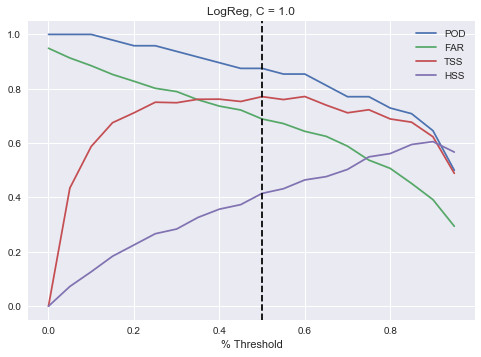

In [67]:
plt.plot(thresh, POD_th, label='POD')
plt.plot(thresh, FAR_th, label='FAR')
plt.plot(thresh, TSS_th, label='TSS')
plt.plot(thresh, HSS_th, label='HSS')
plt.xlabel('% Threshold')
plt.axvline(0.5, linestyle = '--', c = 'black')
plt.title('LogReg, C = 1.0')
plt.legend()

### Logisitic Regression Test set

Now use the SEPClass predict method to make predictions on the test set and print out a report card

In [ ]:
%%capture cap --no-stderr

sepLR.predict(X_test, y_test)

In [ ]:
numfeat = len(sepLR.allmyfeatures.get_feature_names())
fname = 'sepLR_test_nfeat%i_c%i' % (numfeat,sepLR.estimator.C)
with open('reports/'+fname+'.txt', 'w') as f:
    f.write(cap.stdout)

In [ ]:
#investigate how the skill changes by altering the decision threshold
sepLR.y_test_pred_prob

thresh = np.arange(0,1.0,0.05)

POD_th = []
FAR_th = []
TSS_th = []
HSS_th = []
for th in thresh:
    
    #convert to binary 1 or 0 for prediction of an SEP event at this threshold 
    thresh_y_pred = (sepLR.y_test_pred_prob[:,1] > th).astype(int)
    
    #calculate the confusion matric for this threshold
    tn_th, fp_th, fn_th, tp_th = confusion_matrix(sepLR.y_test, thresh_y_pred).ravel()
    
    #calculate and record the POD, FAR, TSS, and HSS at this threshold
    POD_th.append(tp_th/(tp_th + fn_th))
    FAR_th.append(fp_th/(tp_th + fp_th))
    TSS_th.append(tss_score(sepLR.y_test, thresh_y_pred))
    HSS_th.append(hss_score(sepLR.y_test, thresh_y_pred))
    
plt.plot(thresh, POD_th, label='POD')
plt.plot(thresh, FAR_th, label='FAR')
plt.plot(thresh, TSS_th, label='TSS')
plt.plot(thresh, HSS_th, label='HSS')
plt.xlabel('% Threshold')
plt.axvline(0.5, linestyle = '--', c = 'black')
plt.title('LogReg, C = 1.0')
plt.legend()

### Exploration of model performance

Show the top features for both the positive and negative class

In [ ]:
sepLR.show_topX(num=3)

Miclassified events sorted by flare latitude and longitudinal position and flare SXR peak flux.

In [ ]:
# create pandas dataframe with training features and y labels plus predictions
feat_names = [n.split('__')[1] for n in sepLR.allmyfeatures.get_feature_names() ]
dfFeatTrain = pd.DataFrame(data = X_train, columns = feat_names )
dfFeatTrain['y'] = sepLR.y_train
dfFeatTrain['y_pred'] = sepLR.y_train_pred

#determine false alarms and missed events
FA = dfFeatTrain.query('y == 0 and y_pred == 1')
Miss = dfFeatTrain.query('y == 1 and y_pred == 0')


In [ ]:

#plot of flare Lat and Long vs SXR peak flux
fig, (ax1, ax2) = plt.subplots(1,2, figsize = [15,5])
fig.suptitle('SEP event Misses and False Alarms')
ax1.scatter(FA.EW, FA.NS, marker = 'o',s = FA.FlrPeakFlux/dfFeatTrain.FlrPeakFlux.max()*1000,c='b', label = 'FA')
ax1.scatter(Miss.EW, Miss.NS,s = Miss.FlrPeakFlux/dfFeatTrain.FlrPeakFlux.max()*1000, c='r', label = 'Miss')
ax1.set_title('Flare SXR Peak')
ax1.legend()

#plot of flare Lat and Long vs SXR Integrated flux
ax2.scatter(FA.EW, FA.NS, marker = 'o',s = FA.FlrIntFlux2/dfFeatTrain.FlrIntFlux2.max()*100,c='b'*1000, label = 'FA')
ax2.scatter(Miss.EW, Miss.NS,s = FA.FlrIntFlux2/dfFeatTrain.FlrIntFlux2.max()*1000, c='r', label = 'Miss')
ax2.set_title('Flare SXR Int Flux')
ax2.legend()


****
# Adaboost with Decision Trees

****

In [68]:
#Initialize SEPClass instance with an estimator of choice - here Decision Trees

#Set up the decision tree classifier
dtc_keywords = {'max_depth':1, 'max_features':None,'random_state':1230}
dtc = trees(**dtc_keywords)

#Set up the SEP class with the AdaBoost Classifier
clf_keywords = {'random_state':1230}
sepDT = SEPClass(AdaBoostClassifier(dtc,**clf_keywords))

#Turn off features. Options: BalchFeat, RawFeat,LocFeatures
sepDT.allmyfeatures.set_params()

# convert each event into features and labels 
X_train = sepDT.build_train_features(X_train0)    
y_train = y_train0

X_test = sepDT.build_train_features(X_test0)    
y_test = y_test0

#standardization - don't standardize the first 2 columns - these are the binary type II/IV features
scaler = preprocessing.StandardScaler().fit(X_train[:,2::])

X_train = np.hstack([X_train[:,0:2], scaler.transform(X_train[:,2::])]) 
X_test = np.hstack([X_test[:,0:2], scaler.transform(X_test[:,2::]) ]) 




### Hypertune Decision Tree parameters with GridSearchCV

In [70]:
## Tune the tree
#dtc_params = {'class_weight':['balanced',None]}
#dtc_search = GridSearchCV(dtc,dtc_params,scoring = metric6)
#dtc_search.fit(X_train,y_train)
#dtc_keywords.update(dtc_search.best_params_)
#print(dtc_search)
#print(dtc_search.best_params_)

# Tune Adaboost
dtc_keywords = {'criterion':'gini', 'class_weight':None, 'max_depth':1, 'max_features':None,'random_state':1230}
dtc = trees(**dtc_keywords)

clf_keywords = {'n_estimators':500, 'random_state':1230}
clf = AdaBoostClassifier(dtc,**clf_keywords)

#clf_params = {'n_estimators':np.arange(2000,4000,1000),'learning_rate':[0.01, 0.1, 1.0,2.0,3.0,10.0]}
clf_params = {'learning_rate':[0.01, 0.1, 1.0,2.0,3.0,10.0]}
clf_search = GridSearchCV(clf,clf_params, scoring = metric6)
clf_search.fit(X_train,y_train)
clf_keywords.update(clf_search.best_params_)
print(dtc)
print(clf_search)
print(clf_search.best_params_)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=1,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=1230,
            splitter='best')
GridSearchCV(cv=None, error_score='raise',
       estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=1,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=1230,
            splitter='best'),
          learning_rate=1.0, n_estimators=500, random_state=1230),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'learning_rate': [0.01, 0.1, 1.0, 2.0, 3.0, 10.0]}

#### Tunning to HSS
Plot of number of estimators vs HSS scorer

In [75]:
hss_plot0 = []
e = [100,500,1000]
#lr = [0.01,0.1,0.5,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0]
#lr = [0.05,0.1,0.5,1.0,5.0,10.0]

for i in e:

    #train the model
    dtc_keywords = {'criterion':'gini', 'class_weight':'balanced', 'max_depth':1, 'max_features':None,'random_state':1230}
    dtc = trees(**dtc_keywords)

    # set up Adaboost  
    clf_keywords = {'random_state':1230, 'n_estimators' : i, 'learning_rate':1.0}
    sepDT = SEPClass(AdaBoostClassifier(dtc,**clf_keywords))
    #sepDT.allmyfeatures.set_params(RawFeat=None)
    sepDT.fit(X_train,y_train, verbose = False)
    
    hss_plot0.append(hss_score(sepDT.y_train, sepDT.y_train_pred))
    tn, fp, fn, tp=confusion_matrix(sepDT.y_train, sepDT.y_train_pred).ravel()
    #print(tn,fp,fn,tp)
    #print(np.sum(sepLR.y_train))

In [ ]:
hss_plot = []
e = [100,500,1000,3000,8000]
#lr = [0.01,0.1,0.5,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0]
#lr = [0.05,0.1,0.5,1.0,5.0,10.0]

for i in e:

    #train the model
    dtc_keywords = {'criterion':'gini', 'class_weight':None, 'max_depth':1, 'max_features':None,'random_state':1230}
    dtc = trees(**dtc_keywords)

    # set up Adaboost  
    clf_keywords = {'random_state':1230, 'n_estimators' : i, 'learning_rate':.1}
    sepDT = SEPClass(AdaBoostClassifier(dtc,**clf_keywords))
    #sepDT.allmyfeatures.set_params(RawFeat=None)
    sepDT.fit(X_train,y_train, verbose = False)
    
    hss_plot.append(hss_score(sepDT.y_train, sepDT.y_train_pred))
    tn, fp, fn, tp=confusion_matrix(sepDT.y_train, sepDT.y_train_pred).ravel()
    #print(tn,fp,fn,tp)
    #print(np.sum(sepLR.y_train))
    


print(sepDT)  

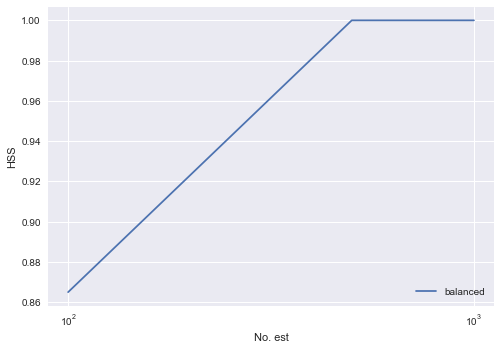

In [76]:
#plt.plot(e, hss_plot,c='r',label = 'unbalanced')
plt.plot(e, hss_plot0,label = 'balanced')
plt.ylabel("HSS")
plt.xlabel("No. est")
plt.xscale('log')
plt.legend(loc = 'lower right')

### Use the tuned hyperparameters to train the Adaboost Model

In [ ]:
%%capture cap --no-stderr

#train the model

# set up tree
dtc_keywords = {'criterion':'gini', 'class_weight':None, 'max_depth':1, 'max_features':None,'random_state':1230}
dtc = trees(**dtc_keywords)

# set up Adaboost
clf_keywords = {'learning_rate': 0.1, 'n_estimators':1000, 'random_state':1230}
clf = AdaBoostClassifier(dtc,**clf_keywords)

sepDT = SEPClass(AdaBoostClassifier(dtc,**clf_keywords),folds=4)
#sepLR.allmyfeatures.set_params(RawFeat=None)
sepDT.fit(X_train,y_train)

In [ ]:
numfeat = len(sepDT.allmyfeatures.get_feature_names())
fname = 'sepDT_train_f%i_nfeat%i_e%i_l%.2f' % (sepDT.folds, numfeat,sepDT.estimator.n_estimators,sepDT.estimator.learning_rate)
with open('reports/'+fname+'.txt', 'w') as f:
    f.write(cap.stdout) 

### Adaboost Test set

Now use the SEPClass predict method to make predictions on the test set and print out a report card

In [ ]:
%%capture cap --no-stderr
sepDT.predict(X_test, y_test)



In [ ]:
numfeat = len(sepDT.allmyfeatures.get_feature_names())
fname = 'sepDT_test_f%i_nfeat%i_e%i_l%.2f' % (sepDT.folds, numfeat,sepDT.estimator.n_estimators,sepDT.estimator.learning_rate)
with open('reports/'+fname+'.txt', 'w') as f:
    f.write(cap.stdout)

In [ ]:
len(dfTrain.query('sep == 1'))

### Exploration of Adaboost model performance

Show the top features for both the positive and negative class

In [ ]:
#sepDT.show_topX(num=3)

Miclassified events sorted by flare latitude and longitudinal position and flare SXR peak flux.

In [ ]:
# create pandas dataframe with training features and y labels plus predictions
feat_names = [n.split('__')[1] for n in sepDT.allmyfeatures.get_feature_names() ]
dfFeatTrain = pd.DataFrame(data = X_train, columns = feat_names )
dfFeatTrain['y'] = sepDT.y_train
dfFeatTrain['y_pred'] = sepDT.y_train_pred

#determine false alarms and missed events
FA = dfFeatTrain.query('y == 0 and y_pred == 1')
Miss = dfFeatTrain.query('y == 1 and y_pred == 0')


In [ ]:

#plot of flare Lat and Long vs SXR peak flux
fig, (ax1, ax2) = plt.subplots(1,2, figsize = [15,5])
fig.suptitle('SEP event Misses and False Alarms')
ax1.scatter(FA.EW, FA.NS, marker = 'o',s = FA.FlrPeakFlux/dfFeatTrain.FlrPeakFlux.max()*1000,c='b', label = 'FA')
ax1.scatter(Miss.EW, Miss.NS,s = Miss.FlrPeakFlux/dfFeatTrain.FlrPeakFlux.max()*1000, c='r', label = 'Miss')
ax1.set_title('Flare SXR Peak')
ax1.legend()

#plot of flare Lat and Long vs SXR Integrated flux
ax2.scatter(FA.EW, FA.NS, marker = 'o',s = FA.FlrIntFlux/dfFeatTrain.FlrIntFlux.max()*100,c='b'*1000, label = 'FA')
ax2.scatter(Miss.EW, Miss.NS,s = FA.FlrIntFlux/dfFeatTrain.FlrIntFlux.max()*1000, c='r', label = 'Miss')
ax2.set_title('Flare SXR Int Flux')
ax2.legend()


****

# SVM

*****

### Initialize SEP object and create feature data

The SVM classifier to initialize an SEP object and generate the feature data for training and test sets.

NOTE: remember to set sepSVM.allmyfeatures.set_params(LocFeatures=None,RawFeat=None) correctly here and a few cells later after the gridsearchcv. Need to find away to update the object keywords with the gridsearchcv best_params without having to reintialze the object.

In [ ]:
#Initialize SEPClass instance with an estimator of choice - here SVM
#with estimator specific keywords 
keywordsSVM = {'random_state':1230, 'class_weight':'balanced','probability':True}         #probability set here just to prevent SEPclass \
                                                                #crashing at y_train_pred_prob

sepSVM = SEPClass(SVC(**keywordsSVM))

#Turn off features. Options: BalchFeat, RawFeat,LocFeatures
sepSVM.allmyfeatures.set_params(LocFeatures=None,RawFeat=None)

# convert each event into features and labels 
X_train = sepSVM.build_train_features(X_train0)    
y_train = y_train0

X_test = sepSVM.build_train_features(X_test0)    
y_test = y_test0

#standardization
scaler = preprocessing.StandardScaler().fit(X_train[:,0:2])

X_train = np.hstack([scaler.transform(X_train[:,0:2]), X_train[:,2:4]]) 
X_test = np.hstack([scaler.transform(X_test[:,0:2]), X_test[:,2:4]]) 



GridSearchCV results

In [ ]:
#hyperparameter ranges
#CV_dictSVM = {'C':np.array([1.e-8, 1.e-7, 1e-6, 1e-5, 1.e-4, 1.e-4, 1.e-3, 1.e-2, 1.e-1, 1.0, 10., 100.0]), \
#              'kernel':['linear', 'poly', 'rbf', 'sigmoid']}

CV_dictSVM = {'C':np.array([1.e3, 1.e4, 1.e5, 1.e6, 1.e7, 1.e8]), 'gamma':['auto','scale']}

##note passing SEPClass object sep directly to gridsearchcv
cv_searchSVM = GridSearchCV(estimator = sepSVM.estimator, param_grid = CV_dictSVM, scoring = metric6, cv=5)   
cv_searchSVM.fit(X_train,y_train)
cv_resultSVM = cv_searchSVM.best_params_
print(cv_resultSVM)

In [ ]:
svm_hss_plot = []
#svm_c = np.arange(0.05,2.0,0.05)
svm_c = np.array([1.e-3, 1.e-2, 1.e-1, 1.0, 10., 100.0,1.e3, 1.e4, 1.e5, 1.e6])
for i in svm_c:

    keywordsSVM.update({'C': i, 'kernel': 'rbf'})
    #print(keywordsLR)
    sepSVM = SEPClass(SVC(**keywordsSVM),threshold = 0.5)
    sepSVM.allmyfeatures.set_params(LocFeatures=None,RawFeat=None)
    sepSVM.fit(X_train, y_train, verbose = False)

    svm_hss_plot.append(hss_score(sepSVM.y_train, sepSVM.y_train_pred))
    tn, fp, fn, tp=confusion_matrix(sepSVM.y_train, sepSVM.y_train_pred).ravel()
    #print(tn,fp,fn,tp)
    #print(np.sum(sepLR.y_train))
    
plt.plot(c, svm_hss_plot, 'o')
plt.ylabel("HSS")
plt.xlabel("C")
plt.xscale('log')
    
print(sepSVM) 

In [ ]:
#train the model
#keywordsSVM.update(cv_resultSVM)
sepSVM = SEPClass(SVC(**keywordsSVM))
sepSVM.allmyfeatures.set_params(LocFeatures=None,RawFeat=None)
sepSVM.fit(X_train, y_train)

### Hypertune Logisitic Regression parameters with GridSearchCV

Scorers to asses opitimization of hyperparameters using GridSearchCV

****
# Balch SEP forecast

****

SEP forecasts with machine learning techniques are compared to forecasts made using the technique outlined in the Balch 2008 paper. A statitical look up table is created for sep events and control events between 1986 and 2004. The sep event probability lookup table is 3 Dimensional with feature binning consisting of: 

5 categories of integrated flux: <0.026, 0.026-0.085, 0.085-0.275, 0.275-0.895, >0.895  
5 categories of x-ray class: <= M2, M3-M8, M9-X1,X2-X6, >= X7  
4 categories of radio type: None, type II, type IV, Both (if unknown, ignore radio event counts)  

In instances where there are not enough sample events is not enough, the dimensionality of the lookup table is collased to give the required bin statistics.

Validation metrics given in Balch 08 were mostly for the training data - where the model was validated using the same events that were used to develope the lookup table. A categorical HSS score of 0.47 was found. An effort to recover a test score was carried out by randomly splitting the data set into 2 groups, training on one half and testing on the other. 30 trials were conducted with a mean HSS of 0.46 +/- XXX. 

In [ ]:
import sunpy.instr
import sunpy
import sunpy.instr
import astropy.units as u

In [ ]:
def intflux_ind(INTFLX):
    """Figure out the integrated flux 'index' """
    
    if (INTFLX < 0.026): xi = 0;
    if np.logical_and((0.026  <= INTFLX), (INTFLX < 0.085)):  xi = 1;
    if np.logical_and((0.085  <= INTFLX), (INTFLX < 0.275)):  xi = 2;
    if np.logical_and((0.275  <= INTFLX), (INTFLX < 0.895)):  xi = 3;
    if (0.895  <= INTFLX): xi = 4;
        
    return xi

In [ ]:
def pkflux_ind(PKFLUX):

    """figure out the x-ray class index"""

    #Flare peak flux to X-ray class
    xrcls = sunpy.instr.goes.flux_to_flareclass(PKFLUX * u.watt/u.m**2)

    #Get the class
    cxray = xrcls[0]
    
    #numerical
    nxray = int(xrcls[1])

    #Calculate index
    xci = 0;    # default
    if (cxray == 'M'):
        if (nxray <= 2): xci = 0
        if np.logical_and((nxray > 2), (nxray <= 8)): xci = 1
        if (nxray > 8): xci = 2
            
    if (cxray == 'X'):
        if (nxray <=1): xci = 2
        if np.logical_and((nxray > 1), (nxray <= 6)): xci = 3
        if (nxray > 6): xci = 4
            
    return xci

In [ ]:
def radio_burst_ind(typeII, typeIV, radiopatrol):
    
    """figure out the radio burst index"""
    
    #print("# no radio ", len(np.where(radiopatrol == 0)))
    #print(radiopatrol)
    
    if (int(radiopatrol) == 0): 
        #print("no radio patrol")
        ri = -1 
    else:
        if np.logical_and((typeII == 0),(typeIV == 0)): ri =  0 # none
        if np.logical_and((typeII == 1),(typeIV == 0)): ri =  1 # type II only
        if np.logical_and((typeII == 0),(typeIV == 1)): ri =  2 # type IV only
        if np.logical_and((typeII == 1),(typeIV == 1)): ri =  3 # both

    return ri

    

In [ ]:
def sep_prob(data):

    #probability of an sep event
    sep_probability = np.zeros(len(data))
    
    #loop through all events (sep + ctrl) dataframe
    for i in range(len(data)):    
    
        #determine the bin index for flare SXRintegrated flux
        xi = intflux_ind(data.FlrIntFlux2.iloc[i])
        
        #determine the bin index for the flare peak flux
        xci = pkflux_ind(data.FlrPeakFlux.iloc[i])
        
        #determine the bin for index for radio burts
        ri = radio_burst_ind(data.TypeII.iloc[i], data.TypeIV.iloc[i], data.radiopatrol.iloc[i])
        
        #sep events
        events = np.array([  
        #INTFLX < 0.026...
            [ [0, 0, 1, 0],    # X <= M2
              [1, 0, 0, 0],    # X from M3-M8	  
              [0, 0, 0, 0],    # X from M9-X1	  
              [0, 0, 0, 0],    # X from X2-X6	  
              [0, 0, 0, 0]     # X >= X7
            ], 
        #INTFLX from 0.026 to 0.085
            [ [0, 0, 0, 3],    # X <= M2
              [2, 0, 0, 3],    # X from M3-M8	  
              [1, 1, 0, 0],    # X from M9-X1	  
              [0, 0, 0, 0],    # X from X2-X6	  
              [0, 0, 0, 0]     # X >= X7
            ],
        #INTFLX from 0.085 to 0.275
            [ [0, 1, 0, 0],    # X <= M2
              [2, 2, 7, 6],    # X from M3-M8	  
              [1, 0, 0, 2],    # X from M9-X1	  
              [1, 0, 0, 3],    # X from X2-X6	  
              [0, 0, 0, 0]     # X >= X7
            ],
        #INTFLX from 0.275 to 0.895
            [ [0, 1, 0, 0],    # X <= M2
              [0, 1, 0, 3],    # X from M3-M8	  
              [2, 1, 2, 6],    # X from M9-X1	  
              [1, 0, 3,14],    # X from X2-X6	  
              [0, 1, 0, 5]     # X >= X7
            ],
        #INTFLX > 0.895
            [ [0, 0, 0, 0],    # X <= M2
              [0, 0, 0, 0],    # X from M3-M8	  
              [0, 0, 0, 0],    # X from M9-X1	  
              [1, 0, 3, 2],    # X from X2-X6	  
              [0, 0, 2, 3]     # X >= X7
            ]
            ])


        samples = np.array([ 
        # INTFLX < 0.026...
            [ [405, 26, 8, 8], # X <= M2
              [56,  16, 2, 2], # X from M3-M8	  
              [0, 0, 0, 0],    # X from M9-X1	  
              [0, 0, 0, 0],    # X from X2-X6	  
              [0, 0, 0, 0]     # X >= X7
            ],
        # INTFLX from 0.026 to 0.085
            [ [257, 15, 12, 8], # X <= M2
              [133, 24, 9, 16], # X from M3-M8	  
              [38,  11, 4, 7],     # X from M9-X1	  
              [12,   1, 0, 2],     # X from X2-X6	  
              [0,    0, 0, 0]      # X >= X7
            ],
        # INTFLX from 0.085 to 0.275
            [ [34,  2,  4,  2], # X <= M2
              [48, 11, 12, 16], # X from M3-M8	  
              [36, 10,  4, 12],    # X from M9-X1	  
              [18,  9,  4, 10],    # X from X2-X6	  
              [0,   0,  0,  0]     # X >= X7
            ],
        # INTFLX from 0.275 to 0.895
            [ [1,  0, 0,  0],    # X <= M2
              [1,  2, 2,  4],    # X from M3-M8	  
              [11, 1, 4,  8],    # X from M9-X1	  
              [14, 5, 4, 23],    # X from X2-X6	  
              [0,  1, 0,  7]     # X >= X7
            ],
        # INTFLX > 0.895
            [ [0, 0, 0,  0],    # X <= M2
              [1, 0, 0,  0],    # X from M3-M8	  
              [1, 0, 0,  0],    # X from M9-X1	  
              [2, 0, 3,  5],    # X from X2-X6	  
              [0, 0, 2, 10]     # X >= X7
            ]
        ])

        #print(events.shape)
        #print(samples.shape)
        
        
        #If radiotype is unknown or sample size is less than ten
        #it is required to collapse the radio counts
        if np.logical_or((ri == -1),(samples[xi, xci, ri] < 10)):
            #print("samples less than 10")
            #if (ri == -1):
                #print("unknown radio")
            
            samples2 = 0
            events2 = 0
            for i in range(4):
                samples2 += samples[xi, xci, i]
                events2 += events[xi, xci, i]

            # It may be necessary to collapse the xray class as well           
            if (samples2 < 10):
                #print("samples2 less than 10")
                samples3 = 0
                events3 = 0
                for i in range(5):
                    for j in range(4):
                        samples3 += samples[xi, i, j]
                        events3 += events[xi, i, j]
                        
                #return the probability estimate
                if samples3 > 0:
                    sep_probability[i] =  1.0*events3/samples3;
                else:
                    print("nan")
                    sep_probability[i] = np.nan

            sep_probability[i] = 1.0*events2/samples2;

        sep_probability[i] = 1.0*events[xi, xci, ri]/samples[xi, xci, ri]
        
    return sep_probability

In [ ]:
#metrics

#TSS
def tss_score(y, y_pred):
    tn, fp, fn, tp=confusion_matrix(y, y_pred).ravel()
    tss = tp / (tp + fp + fn)
    return tss


#HSS
def hss_score(y, y_pred):
    tn, fp, fn, tp=confusion_matrix(y, y_pred).ravel()
    E = ((tp + fn)*(tp + fp) + (fp + tn)*(fn + tn)) / len(y)
    HSS = (tp + tn - E)/(len(y) - E)
    return HSS
        
def pod_far_pc(y, y_pred):
    tn, fp, fn, tp=confusion_matrix(y, y_pred).ravel()
    
    pod = tp / (tp + fn)
    far = fp / (tp + fp)
    pc = (tp + tn)/ len(y)
    
    return pod, far, pc  


    

In [ ]:
#read in the original Balch SEP event list with added CME speed and GOES T and EM
orig_data = pd.read_excel("ctrlevents.v8p.xls")

#adding y label column indicating positive and negative SEP events - SEP events have Association = ProtonFlare
orig_data['sep'] = orig_data.Association.str.contains('^Proton').astype(int)

#rename radiopatrol
orig_data.rename(columns={"Rpatrol":'radiopatrol'}, inplace=True)

#radiopatrol to int
orig_data.radiopatrol = (orig_data.radiopatrol.str.lower() == "yes").astype(int)

#convert the type II and type IV association to binary 
orig_data.TypeII = (orig_data.TypeII.str.lower() == "yes").astype(int)
orig_data.TypeIV = (orig_data.TypeIV.str.lower() == "yes").astype(int)

# Remove rows where optlocation = nan
#orig_data = orig_data[orig_data.optlocation.astype('str') != 'nan']

#shuffle the events so they are not organized 
#orig_data = shuffle(orig_data)

#save the shuffled dataframe -- commented out to prevent resaving
#orig_data.to_csv("AllEvtsShuffled_1986_2004.csv")



In [ ]:
#read in the shuffled dataframe of original sep+ctrl events from 1986 - 2004
#orig_data = pd.read_csv("AllEvtsShuffled_1986_2004_cme.csv")

#pull out feature columns
data_B08 = orig_data[['FlrOnset','Flrmaxtime','FlrPeakFlux','FlrIntFlux2','TypeII','TypeIV','optlocation','FlrIntFlux','radiopatrol','sep']]
#data_B08 = orig_data[['FlrOnset','Flrmaxtime','FlrPeakFlux','FlrIntFlux2','TypeII','TypeIV','optlocation','tchianti','emchianti','FlrIntFlux','radiopatrol','sep']]
#data_B08 = data_B08.query('radiopatrol == 1')

#Use Sep object with LogReg just to featurize the data with the location
keywords = {'random_state':1230, 'max_iter':150}

sepLR = SEPClass(LogisticRegression(**keywords),threshold = 0.5)

#Turn off features. Options: BalchFeat, RawFeat,LocFeatures
sepLR.allmyfeatures.set_params(LocFeatures = None, RawFeat=None)

# convert each event into features and labels 
X_train_B08 = sepLR.build_train_features(data_B08)    
y_train_B08 = np.array(data_B08.sep, dtype=int)

feat_names = [n.split('__')[1] for n in sepLR.allmyfeatures.get_feature_names() ]
dfXtrain08 = pd.DataFrame(data = X_train_B08, columns = feat_names )
dfXtrain08['sep'] = y_train_B08
dfXtrain08['radiopatrol'] = orig_data.radiopatrol

#how manhy events occur behind the limb
#dfXtrain08.query('EW > 90.0 or EW < -90.0')

#caluclate sep event probabilities from balch 2008 table
sp = sep_prob(dfXtrain08)

#compare with actual labels
threshold = 0.3
sep_class = (sp > threshold).astype(int)

#add to data frame
dfXtrain08['sep_balch'] = sep_class.tolist()

#confusion matrix
tn, fp, fn, tp=confusion_matrix(dfXtrain08.sep, dfXtrain08.sep_balch).ravel()
print("True Pos: %i, True Neg: %i, False Pos: %i,. False Neg: %i\n" % (tp,tn,fp,fn))

tss = tss_score(dfXtrain08.sep, dfXtrain08.sep_balch)
hss = hss_score(dfXtrain08.sep, dfXtrain08.sep_balch)
pod, far, pc = pod_far_pc(dfXtrain08.sep, dfXtrain08.sep_balch)



print("TSS: %.4f, HSS:%.4f" % (tss, hss))
print("POD: %.4f, FAR:%.4f, PC:%.4f" % (pod, far, pc))

In [ ]:
#tp = 60
#fn = 67
#tn = 3611
#fp = 45

#E = ((tp + fn)*(tp + fp) + (fp + tn)*(fn + tn)) / len(orig_data)
#HSS = (tp + tn - E)/(len(orig_data) - E)

#pod = tp / (tp + fn)
#far = fp / (tp + fp)
#pc = (tp + tn)/ len(orig_data)
    
#print("HSS:%.4f" % (HSS))
#print("POD: %.4f, FAR:%.4f, PC:%.4f" % (pod, far, pc))

In [ ]:
#plot
plt.scatter(np.arange(len(data)),sp)
plt.show()